![Machine Learning for Scientists in a hurry](./fig/Title_ML.png)

# Boilerplate

In [1]:
from IPython.display import Math, HTML, display

def set_css_in_cell_output():
  display(HTML("""<style>
    .div-1 {
        background-color: #EBEBEB;
    }

    .div-2 {
    	background-color: #ABBAEA;
    }

    .div-3 {
    	background-color: #FBD603;
    }
    .div-white {
    	background-color: #FBFBFB;
    }
    h1 {
      color: #002855;
    }
    h2 {
      color: #002855;
    }
</style>
"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)


In [2]:
!pip install watermark

In [3]:
!if [ ! -f helpers.py ]; then wget "https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/helpers.py"; fi

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 6. Support Vector Machines</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## Setup

In [4]:
%load_ext watermark

In [5]:
%watermark

Last updated: 2023-10-22T18:04:47.441102-04:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.14.0

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [6]:
import time
start = time.time()
chapter_number = 6
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import sklearn

In [8]:
%watermark -iv

matplotlib: 3.8.0
sklearn   : 1.3.0
numpy     : 1.25.2



# Support Vector Machines

A Support Vector Machine (SVM) is a machine learning model capable of performing linear and non-linear classification.
This algorithm is a discriminative classifier formally defined by a separating hyperplane. In other words, we should provide labeled training data (supervised learning), and the algorithm outputs an optimal hyperplane that categorizes new examples, where optimal means that we have the maximum distance between data points of both classes. In two dimensional space this hyperplane is a line dividing a plane into two parts where in each class lay on either side.

Supportvectorsarethedatapointsthatlieclosest to the decision surface (or hyperplane). Using these support vectors, we maximize the margin of the classifier. Deleting the support vectors will change the position of the hyperplane. These are the points that help us build our SVM. In conclusion, SVMs maximize the margin (Winston terminology: the ‘street’) around the separating hyperplane.

We will come back to the Iris dataset to understand how SVM performs classification with 4 features.

# Iris Dataset

First, we get the Iris dataset and from there we will select the petal features (length and width) for setosa and Versicolor. This is done for illustration purposes. We saw on the first episode that setosa and Versicolor are well separated. We say in those cases that the two classes are **linearly separable**

In [9]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1E8)
svm_clf.fit(X, y)

SVC(C=100000000.0, kernel='linear')

## Iris-Setosa vs Iris-Versicolor

Just from plotting to petal length and petal width, we can see that those two sets are well separated. However, the question that we pose is: What is the line that separates those two sets? If new data sets are provided for which we do not know in advance which class of Iris flower they belong, how to classify them.

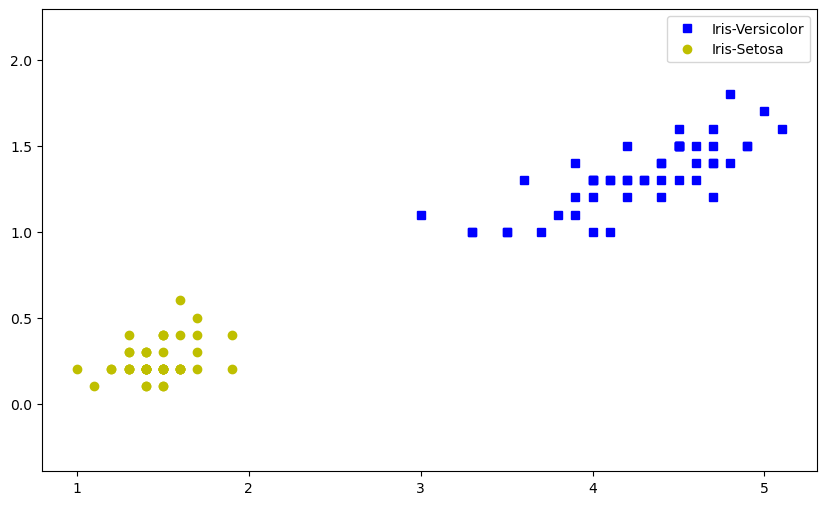

In [10]:
fig, axes = plt.subplots(figsize=(10,6))

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.legend()
axes.set_aspect('equal', 'datalim')

The solution could be to draw a line between those two sets and whatever new data arrives we just look at which side of the space the data points belong.

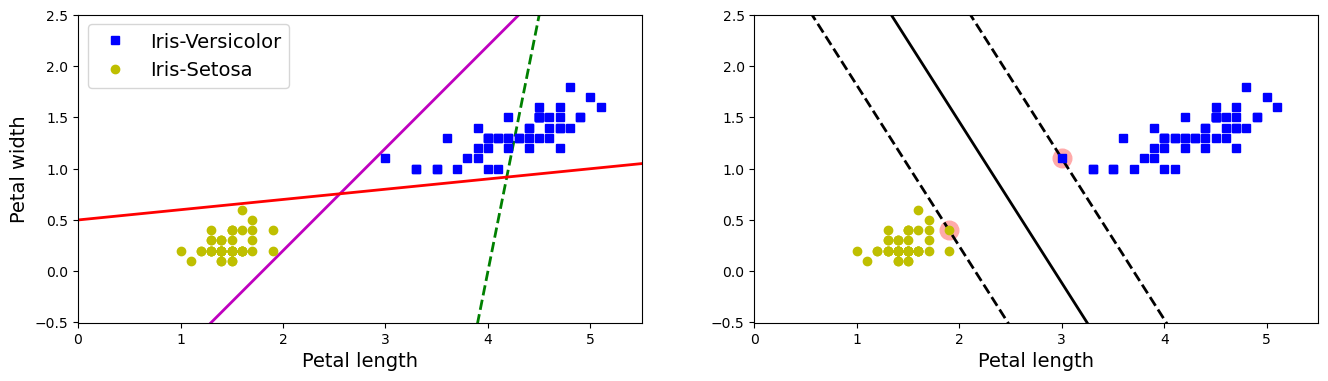

In [11]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax, axes=None):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    if axes is None:
        axes=plt.gca()
    
    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    axes.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    axes.plot(x0, decision_boundary, "k-", linewidth=2)
    axes.plot(x0, gutter_up, "k--", linewidth=2)
    axes.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axes[0].plot(x0, pred_1, "g--", linewidth=2)
axes[0].plot(x0, pred_2, "m-", linewidth=2)
axes[0].plot(x0, pred_3, "r-", linewidth=2)
axes[0].plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
axes[0].plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
axes[0].set_xlabel("Petal length", fontsize=14)
axes[0].set_ylabel("Petal width", fontsize=14)
axes[0].legend(loc="upper left", fontsize=14)
axes[0].axis([0, 5.5, 0, 2])
axes[0].set_aspect('equal', 'datalim')

plot_svc_decision_boundary(svm_clf, 0, 5.5, axes[1])
axes[1].plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
axes[1].plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
axes[1].set_xlabel("Petal length", fontsize=14)
axes[1].axis([0, 5.5, 0, 2]);
axes[1].set_aspect('equal', 'datalim')

As you can see above, there are several ways of drawing lines to separate space. The result of SVM is using the line shown on he right. The two points marked with red are called the **Supporting Vectors**

# Sensitivity to feature scales

SVMs are sensitive to scaling on the features. Scikit-learn provides the function `StandardScaler` to transform the data in a way that the data points look more spread.

`StandardScaler` works by removing the mean and scaling to unit variance

The standard score of a sample $x$ is calculated as:

\begin{equation}
z = \frac{x - u}{s}
\end{equation}
        
where $u$ is the mean of the training samples or zero if optional argument `with_mean=False`, and $s$ is the standard deviation of the training samples or one if optional argument `with_std=False`.

(-2.0, 2.0, -2.0, 2.0)

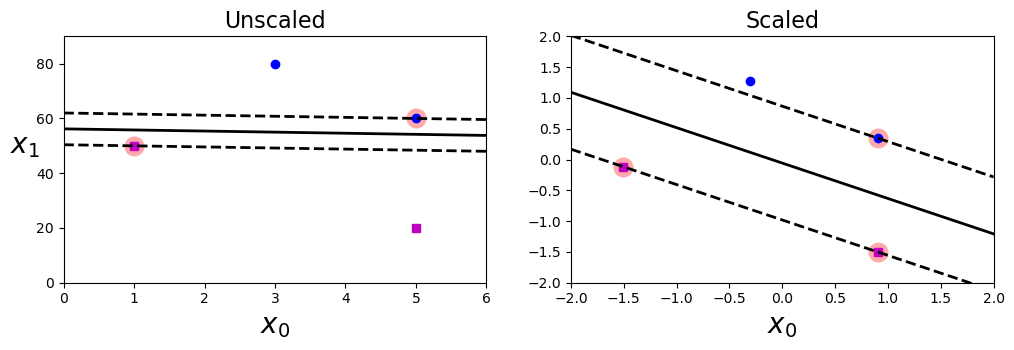

In [12]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

# Sensitivity to outliers

Another problem that affects SVMs is the presence of outliers. Outliers are scattered points that do not belong to the same distribution as most observations.

(0.0, 5.5, 0.0, 2.0)

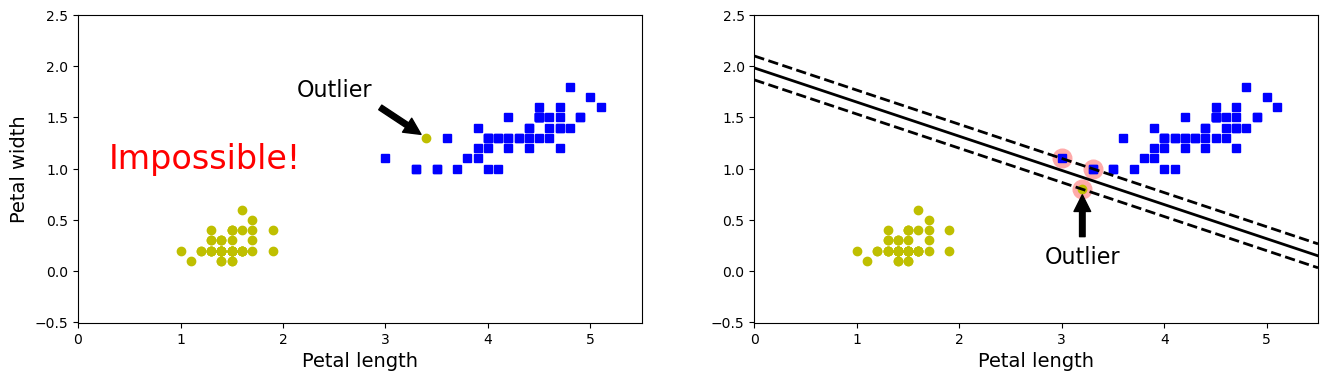

In [13]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.gca().set_aspect('equal', 'datalim')
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plt.gca().set_aspect('equal', 'datalim')
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

The detection of outliers is beyond the scope of this episode but more information can be found on [Scikit Documentation](https://scikit-learn.org/stable/modules/outlier_detection.html)

<img src="fig/outliers.png" alt="Several methods of outlier detection" style="width:800px">

# Large margin *vs* margin violations

We can join the scaling and the SVM on what is called a pipeline. The pipeline will have the fit method and the original data will be scaled during the process.

In [14]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42, dual='auto')),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, dual='auto', loss='hinge', random_state=42))])

And predictions can be made with the `predict` method. These pipelines are often used in SVM as the scaling is often needed for features.

In [15]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

## Soft Margin Classification

From one side, Linear separability is something that we cannot rely on as often features overlap its range. Outliers can often do this task impossible. So it is often desirable to relax the condition of separation and allow some points to be misclassified. A C hyperparameter from SVM allows to do that. When the value is 1 the algorithm tries to maximize the margin but margin violations are heavily penalized. From the other size, a larger C value can increase the margins even more at expense of some points being misclassified.

In [16]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42, dual='auto')
svm_clf2 = LinearSVC(C=10, loss="hinge", random_state=42, dual='auto')

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=10, dual='auto', loss='hinge', random_state=42))])

In [17]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

(4.0, 6.0, 0.8, 2.8)

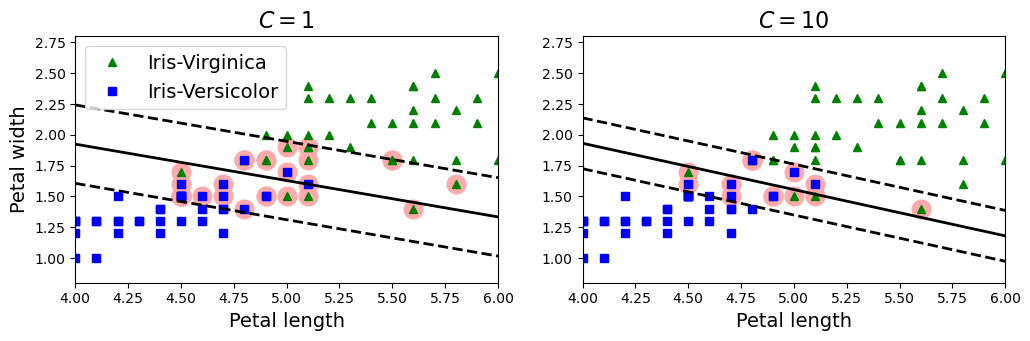

In [18]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])


plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])


# Non-linear classification

Until now we have used `LinearSVC` as the linear separability was assumed. However, many datasets do not follow linear separability. One approach as shown below is using non-linear functions to bend the components in such a way that separability becomes linear.

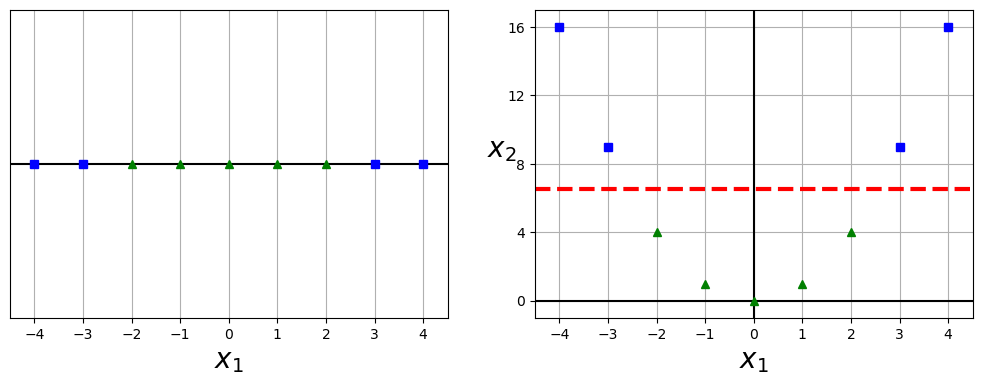

In [19]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)


### The moons database

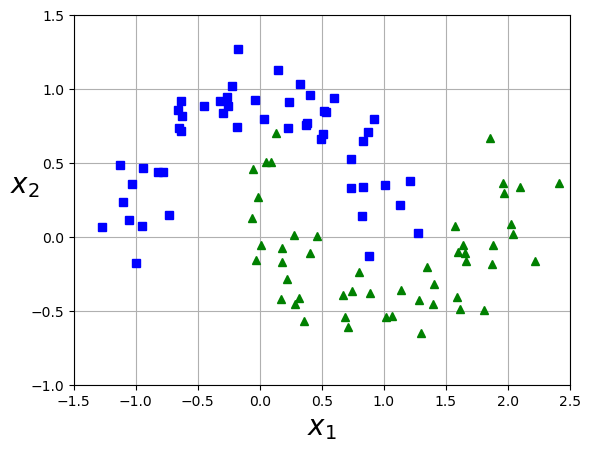

In [20]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [21]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42, dual='auto'))
    ])

polynomial_svm_clf.fit(X, y)

/Users/guilleaf/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, dual='auto', loss='hinge', random_state=42))])

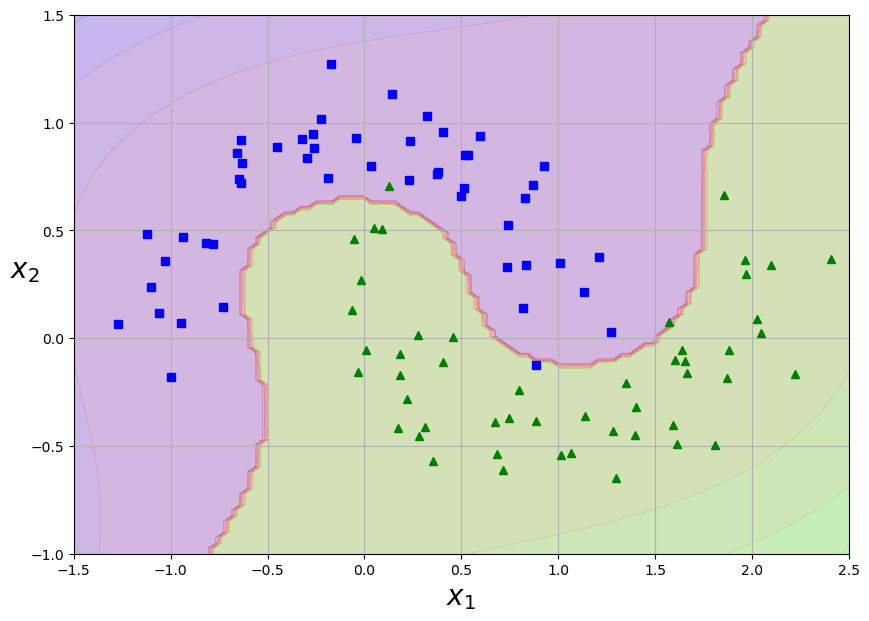

In [22]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes=plt.subplots(figsize=(10,7))
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [23]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [24]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

Text(0.5, 1.0, '$d=10, r=100, C=5$')

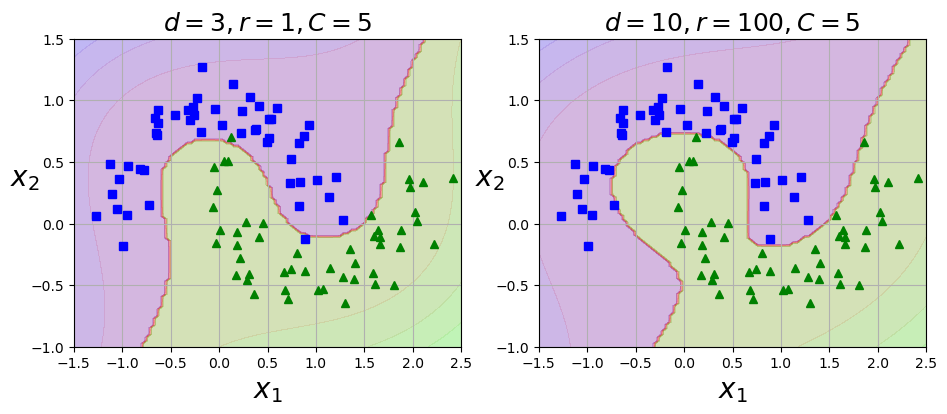

In [25]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

# Exercises for Support Vector Machines

### Generating data

In the following, we generated 100 samples of a synthetic dataset using the **sklearn.datasets.make_classification** function.

This dataset has 2 classes (**n_classes=2**) and 2 features (**n_features=2**). It means that $y \in \{0,1\}$ and $X \in \mathbb{R}^2$

The parameter **class_sep** controls the separability of the class, and in this example, we set this to return a dataset that is linearly separable:

In [26]:
# create a colormap for the points
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

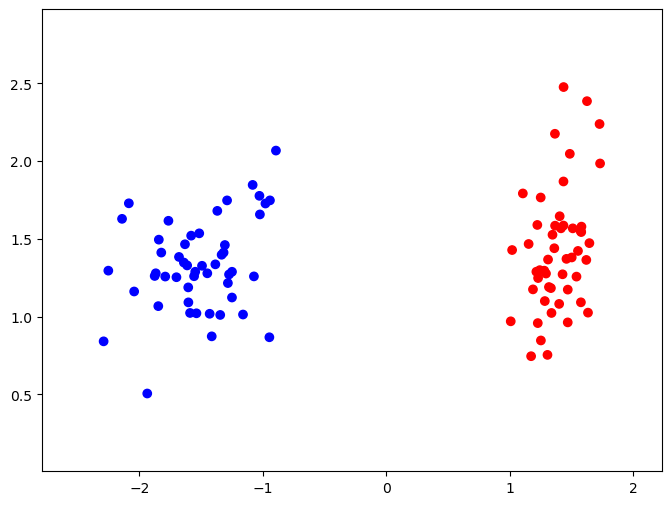

In [27]:
from sklearn import datasets

X, y = datasets.make_classification(n_samples=100, n_classes=2,
                                    n_features=2, n_redundant=0, n_informative=2,
                                    random_state=1, n_clusters_per_class=1, class_sep=1.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

fig,axes=plt.subplots(figsize=(8, 6))
axes.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

# set the graph limits
axes.set_ylim(y_min, y_max)
axes.set_xlim(x_min, x_max);

This function will plot the decision boundary and the support vectors of a model:

In [28]:
def plot_boundary(model, X):
    # create a mesh of points that cover the full graph area
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel()]

    # use the classifier to predict the class of each mesh point
    Z = clf.decision_function(X_grid)
    Z = Z.reshape(xx.shape)

    fig,axes=plt.subplots(figsize=(8, 6))

    # plot the decision boundary
    norm = plt.cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    axes.contourf(xx, yy, Z, 12, cmap=plt.cm.RdBu, alpha=.8, norm=norm)
    # plt.colorbar()

    # plot the decision hyper-planes
    axes.contour(xx, yy, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'],
            levels=[-1., 0, 1.])

    # plot the dataset points
    axes.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

    # plot the support vectors
    SV = clf.support_vectors_
    axes.scatter(SV[:, 0], SV[:, 1], c=y[clf.support_],
            cmap=cm_bright, s=500, marker='x')

    # set the graph limits
    axes.set_ylim(y_min, y_max)
    axes.set_xlim(x_min, x_max);

## Example 1: Linear kernel with high penalty ($C \rightarrow \infty$)

The parameter **C** controls the penalty of the error terms for a soft-margin SVM classifier.

Setting **C** to a high value means that the classifier will try to maximize the margin with a high penalty for misclassified points.

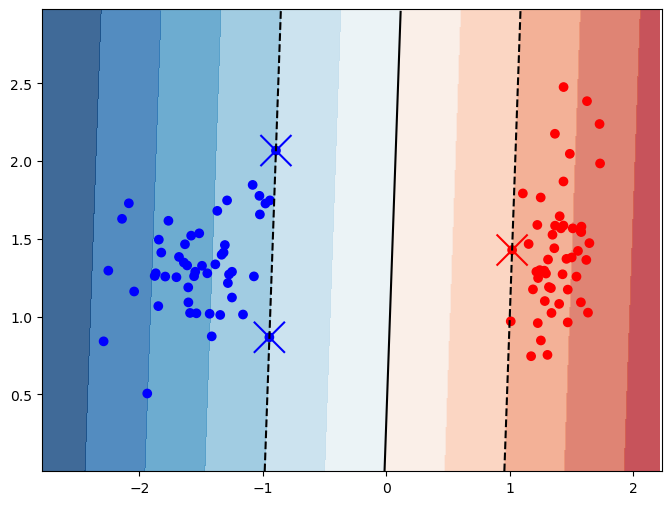

In [29]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1e12)
clf.fit(X, y)

plot_boundary(clf, X)

## Example 2: Linear kernel with low penalty ($C \rightarrow 0$)

Setting **C** to a low value means that the classifier will try to maximize the margin with a small penalty for misclassified points.

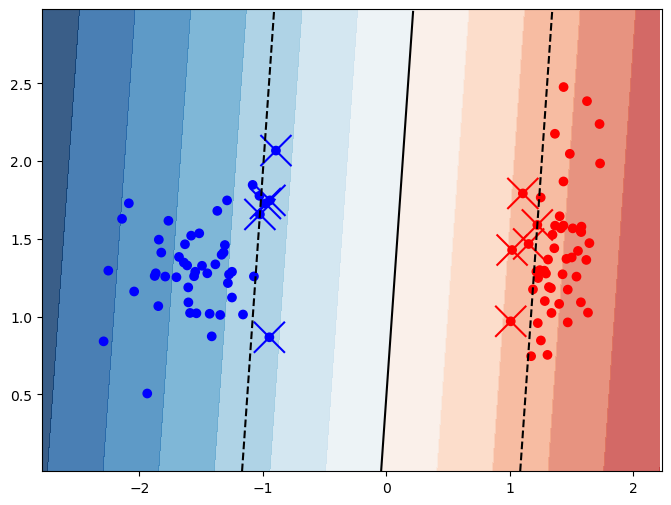

In [30]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1e-1)
clf.fit(X, y)

plot_boundary(clf, X)

## Example 3: RBF kernel with high penalty ($C \rightarrow \infty$) and small $\gamma$:

The Radial Basis Function kernel is given by the function $\exp(-\gamma \left|x-x'\right|^2)$.

When training an SVM with the RBF kernel, two parameters must be considered: $C$ and $\gamma$. The parameter $C$, common to all SVM kernels, trades off the misclassification of training examples against the simplicity of the decision surface. A low $C$ makes the decision surface smooth, while a high $C$ aims at classifying all training examples correctly. $\gamma$ defines how much influence a single training example has. The larger $\gamma$ is, the closer other examples must be to be affected.

Setting **C** to a high value means that the classifier will try to maximize the margin with a high penalty for misclassified points, and will try to classify all training examples correctly.

The parameter **gamma** is the coefficient of the RBF function. Setting **gamma** to a small value means that just a few training examples will influence the model.

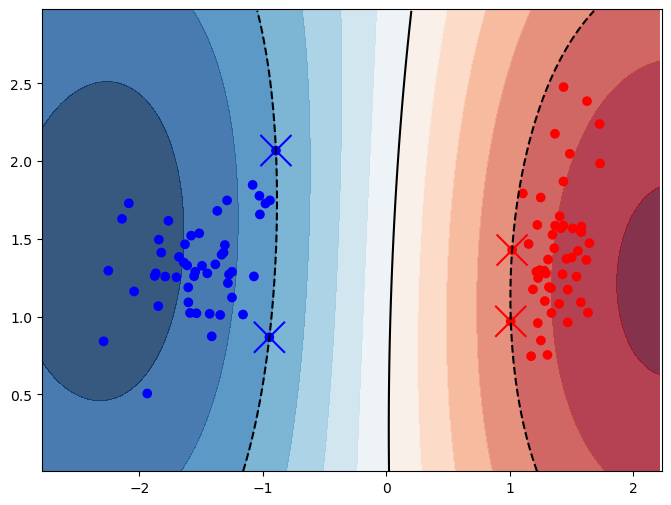

In [31]:
from sklearn import svm

clf = svm.SVC(kernel='rbf', gamma=1e-1, C=1e12)
clf.fit(X, y)

plot_boundary(clf, X)

## Exercise 1: RBF kernel with high penalty ($C \rightarrow \infty$) and high $\gamma$ (e.g., $\gamma = 20$)

In [32]:
# YOUR CODE HERE

## Exercise 2: Check the behavior of the SVM classifiers in the case when the dataset is not linearly separable.

First, create a new dataset that is not linearly separable:

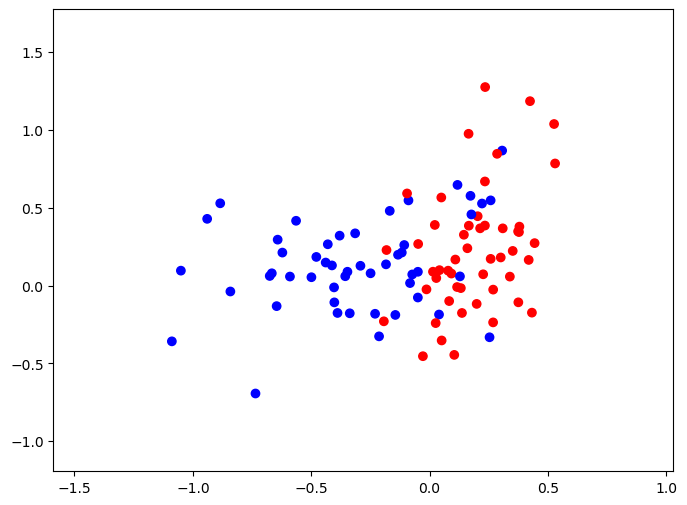

In [33]:
from sklearn import datasets

X, y = datasets.make_classification(n_samples=100, n_classes=2,
                                    n_features=2, n_redundant=0, n_informative=2,
                                    random_state=1, n_clusters_per_class=1, class_sep=0.2)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

fig,axes=plt.subplots(figsize=(8, 6))

axes.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

# set the graph limits
axes.set_ylim(y_min, y_max)
axes.set_xlim(x_min, x_max);

Next, check the behavior of the SVM classifiers with:

Linear kernel with high penalty ($C \rightarrow \infty$)

In [34]:
# YOUR CODE HERE

Linear kernel with low penalty ($C \rightarrow 0$)

In [35]:
# YOUR CODE HERE

RBF kernel with high penalty ($C \rightarrow \infty$) and small $\gamma$ (e.g., $\gamma = 0.1$):

In [36]:
# YOUR CODE HERE

RBF kernel with high penalty ($C \rightarrow \infty$) and high $\gamma$ (e.g., $\gamma = 20$)

In [37]:
# YOUR CODE HERE

---

# Acknowledgments

This notebook is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted to at least Python 3.7. 
 
We acknowledge the support of the National Science Foundation and the US Department of Energy under projects: DMREF-NSF 1434897, NSF OAC-1740111 and DOE DE-SC0016176 is recognized.

<div style="clear: both; display: table;">
<div style="border: none; float: left; width: 40%; padding: 10px">
<img src="fig/NSF.jpg" alt="National Science Foundation" style="width:50%" align="left">
    </div>
    <div style="border: none; float: right; width: 40%; padding: 10px">
<img src="fig/DOE.jpg" alt="National Science Foundation" style="width:50%" align="right">
</div>

---

# References

The snippets above are meant only to give a brief introduction to some of the most popular techniques in machine learning so you can decide whether this kind of analysis might be useful in your research. If it seems like machine learning will be important in your work, you may want to check out some of the resources listed below (arranged roughly from least to most technical):

This list is by no means an exhaustive list of books and resources. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Machine Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Hands-On Machine Learning  with Scikit-Learn and TensorFlow" 
       src="./fig/books/Hands-On Machine Learning  with Scikit-Learn and TensorFlow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Hands-On Machine Learning  with Scikit-Learn and TensorFlow (First Edition [There is a second edition])<br>
      Auréleien Géron<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Python Machine Learning - Raschka" 
       src="./fig/books/Python Machine Learning - Raschka.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Sebastian Raschka and Vahid Mirjalili<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Foundations of Machine Learning - Mohri" 
       src="./fig/books/Foundations of Machine Learning - Mohri.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Foundations of Machine Learning (Second Edition)<br>
      Mehryar Mohri, Afshin Rostamizadeh and Ameet Talwalkar<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Machine Learning - Alpaydin" 
       src="./fig/books/Introduction to Machine Learning - Alpaydin.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Machine Learning (Fourth Edition)<br>
      Ethem Alpaydin<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Machine Learning, a Probabilistic Perspective - Murphy" 
       src="./fig/books/Machine Learning, a Probabilistic Perspective - Murphy.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Kevin P. Murphy<br>
      2012<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Elements of Statistical Learning - Hastie" 
       src="./fig/books/Elements of Statistical Learning - Hastie.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      <a href="https://hastie.su.domains/Papers/ESLII.pdf">Elements of Statistical Learning</a><br>
      Trevor Hastie, Robert Tibshirani, and Jerome Friedman<br>
      2008<br>
  </div>
</div>


### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 

 * [A Friendly Introduction to Machine Learning](https://www.youtube.com/watch?v=IpGxLWOIZy4)

In this 30-minute video, Luis Serrano (head of machine learning at Udacity) offers intuitive, user-friendly introductions to the mechanics that drive several machine learning models, including Naive Bayes, Decision Tree, Logistic Regression, Neural Network, and Support Vector Machine classifiers. This video is a great place to start for those looking for quick intuitions about the ways these algorithms work.

 * [Hands-On Machine Learning with Scikit-Learn and TensorFlow (OREILLY)](http://shop.oreilly.com/product/0636920052289.do)

This OREILLY book offers a great high-level introduction to machine learning with Python. Aurélien Géron guides readers through ways one can use scikit-learn and other popular libraries to build machine learning models in Python. This is a great choice for those who just want to get work done, without necessarily unlocking the insights that would allow one to build models from scratch.

 * [Machine Learning Cheatsheets](https://becominghuman.ai/cheat-sheets-for-ai-neural-networks-machine-learning-deep-learning-big-data-678c51b4b463)

This collection of "cheat sheets" gives concise overviews of the API's and models behind many of the most prominent packages and concepts in machine learning and its allied fields, including different neural network architectures, numerical optimization techniques, algorithms appropriate for different tasks, scikit-learn, pandas, scikit-learn, scipy, ggpot2, dplyr and tidyr, big O notation, and several other topics. Recently identified as the "most popular" article on machine learning in Medium.

 * [Mining of Massive Datasets](http://www.mmds.org/)

This Stanford University course and digital publication offer introductions to a wide array of subtopics in machine learning. The authors focus on helping readers gain an intuitive understanding of how machine learning models work. One of the most lucid and concise treatments of machine learning available on the web.

 * [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

This Stanford University course offers a spectacular introduction to Convolutional Neural Networks, the cornerstone of modern machine learning in the domain of computer vision. If your work involves images or video materials, and you'd like to apply machine learning techniques to your data, this course will help you get up and running with state-of-the-art techniques in convnets.

 * [Machine Learning (Andrew Ng, Coursera)](https://www.coursera.org/learn/machine-learning)

Andrew Ng's Coursera course on machine learning will help you master many of the fundamentals involved in modern machine learning. Professor Ng will guide you through a great deal of the math involved in contemporary machine learning, starting with simple linear classifiers and building up into complex neural network architectures. This class is ideal for those who like to understand the math behind the models they use.
 
 ---

# Back of the Book

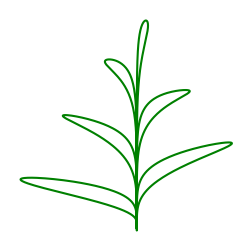

In [38]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [39]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')

Chapter 6 run in 7 seconds
